In [1]:
#import python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#import python packages for working with .cool, .bigwig and .gtf files
import cooler
import bioframe
import cooltools
import pyBigWig
from gtfparse import read_gtf

In [4]:
# import HiC in .cool or .mcool 
# note: if you are importing HiC in .mcool file, you should specify the resolution
clr = cooler.Cooler('[pass to your .cool or .mcool file]/GSE130275_mESC_WT_combined_2.6B.mcool::/12')
resolution = clr.binsize
print(resolution)

3200


In [5]:
# computing the expected values for each diagonal in cis
view_df=pd.DataFrame({'chrom':clr.chromnames,
                      'start':0,
                      'end':clr.chromsizes.values,
                      'name':clr.chromnames})
expected = cooltools.expected_cis(clr, view_df=view_df, nproc=2, chunksize=1_000_000)

In [7]:
# import gene annotation in .gft file to extract gene/transcript information
df_gene0 = read_gtf("[pass to your .gtf file]/mm10.ensGene.gtf")
df_gene0 = df_gene0[df_gene0['feature']=="transcript"]
df_gene0 = df_gene0[['seqname','start','end','strand','gene_id']]
df_gene0['length'] = df_gene0['end']-df_gene0['start']
df_gene0 = df_gene0.sort_values('length', ascending=False).drop_duplicates('gene_id')
df_gene0 = df_gene0.rename(columns = {'seqname': 'chrom'}, inplace = False)
df_gene0 = df_gene0.sort_values(['chrom','start'])
df_gene0 = df_gene0[df_gene0['chrom'].isin(clr.chromnames)]
display(df_gene0)

/Users/hsalari/opt/miniconda3/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
/Users/hsalari/opt/miniconda3/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_name', 'exon_number', 'exon_id']


,chrom,start,end,strand,gene_id,length
0,chr1,3073253,3074322,+,ENSMUSG00000102693,1069
2,chr1,3102016,3102125,+,ENSMUSG00000064842,109
10,chr1,3214482,3671498,-,ENSMUSG00000051951,457016
21,chr1,3252757,3253236,+,ENSMUSG00000102851,479
23,chr1,3365731,3368549,-,ENSMUSG00000103377,2818
...,...,...,...,...,...,...
1449882,chrY,90753057,90763485,+,ENSMUSG00000095134,10428
1449890,chrY,90754513,90754821,-,ENSMUSG00000095366,308
1449895,chrY,90784738,90816439,+,ENSMUSG00000096768,31701
1449950,chrY,90837413,90844040,+,ENSMUSG00000099871,6627


In [8]:
# select a subset of genes based on size
# Note: the minimum size of the gene is better to be at least 20 times higher than HiC resolution
df_gene = df_gene0[(df_gene0['length']<20*resolution)&(df_gene0['length']>10*resolution)]
df_gene = df_gene.reset_index(drop=True)
display(df_gene)

,chrom,start,end,strand,gene_id,length
0,chr1,3466587,3513553,+,ENSMUSG00000089699,46966
1,chr1,4807788,4848410,+,ENSMUSG00000025903,40622
2,chr1,4857814,4897905,+,ENSMUSG00000033813,40091
3,chr1,6214645,6276648,+,ENSMUSG00000025907,62003
4,chr1,6359218,6394731,+,ENSMUSG00000087247,35513
...,...,...,...,...,...,...
3608,chrY,61102247,61134259,+,ENSMUSG00000100667,32012
3609,chrY,70271306,70303343,-,ENSMUSG00000099530,32037
3610,chrY,89713424,89745532,-,ENSMUSG00000100608,32108
3611,chrY,90401248,90433263,+,ENSMUSG00000096178,32015


In [9]:
# compute Intra-gene RNA Pol II (IR) score from PolII ChIP-seq data in BigWig format
pol2 = pyBigWig.open("[pass to your .bigwig file]/GSM4173524_DMSO-N20-input_rep1.bw")
l = len(df_gene)
for i in range(l):
    ch = df_gene.chrom[i]
    start = df_gene.start[i]
    end = df_gene.end[i]
    df_gene.loc[i,'ir_score'] = np.mean(pol2.values(ch,start,end))
df_gene.loc[:,'log2_ir_score'] = np.log2(df_gene['ir_score'])

display(df_gene)

,chrom,start,end,strand,gene_id,length,ir_score,log2_ir_score
0,chr1,3466587,3513553,+,ENSMUSG00000089699,46966,0.259446,-1.946495
1,chr1,4807788,4848410,+,ENSMUSG00000025903,40622,3.726281,1.897736
2,chr1,4857814,4897905,+,ENSMUSG00000033813,40091,4.367942,2.126954
3,chr1,6214645,6276648,+,ENSMUSG00000025907,62003,1.216582,0.282834
4,chr1,6359218,6394731,+,ENSMUSG00000087247,35513,0.303108,-1.722096
...,...,...,...,...,...,...,...,...
3608,chrY,61102247,61134259,+,ENSMUSG00000100667,32012,0.092675,-3.431683
3609,chrY,70271306,70303343,-,ENSMUSG00000099530,32037,0.082806,-3.594123
3610,chrY,89713424,89745532,-,ENSMUSG00000100608,32108,0.083463,-3.582720
3611,chrY,90401248,90433263,+,ENSMUSG00000096178,32015,0.083705,-3.578535


In [16]:
# select gene pairs based on distance and IR scores
# Note1: here we clustered genes based on IR score in three different groups (i.e. Low, Mid, and High)
# Note2: the minimum distance between genes (middle to middle) should be higher than the maximum size of the genes
IR1 = 'High'
IR2 = 'High'
dmin = 20*resolution
dmax = 2_000_000
group = {'Low':1,'Mid':2,'High':3}
df_gene['quartile_ir_score']= pd.qcut(df_gene['log2_ir_score'], 3, labels=False) + 1
paired_sites = bioframe.pair_by_distance(df_gene, min_sep=dmin, 
                                          max_sep=dmax, suffixes=('1', '2'))
paired_sites.loc[:, 'mid1'] = (paired_sites['start1'] + paired_sites['end1'])//2
paired_sites.loc[:, 'mid2'] = (paired_sites['start2'] + paired_sites['end2'])//2
paired_sites['dist'] = abs(paired_sites.mid2-paired_sites.mid1)
sub_paired_sites = paired_sites[(paired_sites['quartile_ir_score1']==group[IR1])&
                             (paired_sites['quartile_ir_score2']==group[IR2])]
sub_paired_sites = sub_paired_sites.reset_index(drop=True)
display(sub_paired_sites)

,chrom1,start1,end1,strand1,gene_id1,length1,ir_score1,log2_ir_score1,quartile_ir_score1,chrom2,...,end2,strand2,gene_id2,length2,ir_score2,log2_ir_score2,quartile_ir_score2,mid1,mid2,dist
0,chr6,54923942,54972612,-,ENSMUSG00000038058,48670,4.303052,2.105360,3,chr6,...,56761911,+,ENSMUSG00000029787,46984,1.639700,0.713432,3,54948277,56738419,1790142
1,chr6,54923942,54972612,-,ENSMUSG00000038058,48670,4.303052,2.105360,3,chr6,...,56879358,+,ENSMUSG00000029781,47299,2.294768,1.198348,3,54948277,56855708,1907431
2,chr6,55038001,55079504,+,ENSMUSG00000029777,41503,4.519499,2.176163,3,chr6,...,56761911,+,ENSMUSG00000029787,46984,1.639700,0.713432,3,55058752,56738419,1679667
3,chr6,55038001,55079504,+,ENSMUSG00000029777,41503,4.519499,2.176163,3,chr6,...,56879358,+,ENSMUSG00000029781,47299,2.294768,1.198348,3,55058752,56855708,1796956
4,chr6,71543917,71582609,+,ENSMUSG00000053119,38692,2.263704,1.178685,3,chr6,...,72899979,-,ENSMUSG00000055239,58865,4.125879,2.044701,3,71563263,72870546,1307283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906,chr11,120380370,120437708,-,ENSMUSG00000039703,57338,3.393511,1.762779,3,chr11,...,120709447,+,ENSMUSG00000025142,36455,4.144247,2.051110,3,120409039,120691219,282180
1907,chr11,120380370,120437708,-,ENSMUSG00000039703,57338,3.393511,1.762779,3,chr11,...,121309896,+,ENSMUSG00000039275,49906,3.609339,1.851735,3,120409039,121284943,875904
1908,chr11,120672992,120709447,+,ENSMUSG00000025142,36455,4.144247,2.051110,3,chr11,...,121309896,+,ENSMUSG00000039275,49906,3.609339,1.851735,3,120691219,121284943,593724
1909,chr11,120672992,120709447,+,ENSMUSG00000025142,36455,4.144247,2.051110,3,chr11,...,121673153,-,ENSMUSG00000046605,56956,1.931737,0.949899,3,120691219,121644675,953456


Text(0.5, 1.0, 'High-High\n32<length<64kb\n64<distance<2000kb')

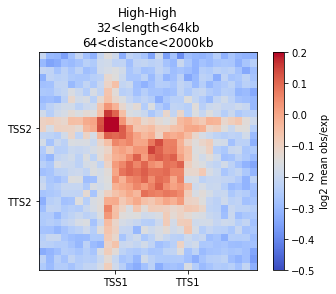

In [26]:
# pileup mtea-gene analysis (PMGA) of inter-gene HiC contact map
def get_row_compressor(old_dimension, new_dimension):
    dim_compressor = np.zeros((new_dimension, old_dimension))
    bin_size = float(old_dimension) / new_dimension
    next_bin_break = bin_size
    which_row = 0
    which_column = 0
    while which_row < dim_compressor.shape[0] and which_column < dim_compressor.shape[1]:
        if round(next_bin_break - which_column, 10) >= 1:
            dim_compressor[which_row, which_column] = 1
            which_column += 1
        elif next_bin_break == which_column:

            which_row += 1
            next_bin_break += bin_size
        else:
            partial_credit = next_bin_break - which_column
            dim_compressor[which_row, which_column] = partial_credit
            which_row += 1
            dim_compressor[which_row, which_column] = 1 - partial_credit
            which_column += 1
            next_bin_break += bin_size
    dim_compressor /= bin_size
    return dim_compressor


def get_column_compressor(old_dimension, new_dimension):
    return get_row_compressor(old_dimension, new_dimension).transpose()

def compress_and_average(array, new_shape):
    # Note: new shape should be smaller in both dimensions than old shape
    return np.mat(get_row_compressor(array.shape[0], new_shape[0])) * \
           np.mat(array) * \
           np.mat(get_column_compressor(array.shape[1], new_shape[1]))

view_df = pd.read_csv('./mm10_arms.txt',sep="\t")
sub_paired_sites['mid1'] = sub_paired_sites['end1']
sub_paired_sites['start1'] = sub_paired_sites['end1']-1
sub_paired_sites['end1'] = sub_paired_sites['end1']+1
sub_paired_sites['mid2'] = sub_paired_sites['end2']
sub_paired_sites['start2'] = sub_paired_sites['end2']-1
sub_paired_sites['end2'] = sub_paired_sites['end2']+1
flank = 2*max(max(sub_paired_sites.length1),max(sub_paired_sites.length2))
stack = cooltools.pileup(clr, sub_paired_sites, view_df=view_df, expected_df=expected, flank=flank)
lm1 = sub_paired_sites.length1[0]//resolution
lm2 = sub_paired_sites.length2[0]//resolution
fm = flank//resolution
m11 = fm-2*lm1
m21 = fm+lm1
m12 = fm-2*lm2
m22 = fm+lm2
mtx0 = stack[m11:m21,m12:m22,0]
stk = np.asarray(compress_and_average(mtx0, (30, 30)))
l = len(sub_paired_sites)
for i in range (1,l):
    lm1 = sub_paired_sites.length1[i]//resolution
    lm2 = sub_paired_sites.length2[i]//resolution
    m11 = fm-2*lm1
    m21 = fm+lm1
    m12 = fm-2*lm2
    m22 = fm+lm2
    mtx0 = stack[m11:m21,m12:m22,i]
    mtx0 = np.asarray(compress_and_average(mtx0, (30, 30)))
    stk = np.dstack((stk,mtx0))
mask1 = np.array(sub_paired_sites.strand1 == '-', dtype=bool)
mask2 = np.array(sub_paired_sites.strand2 == '-', dtype=bool)
stk[:, :, mask1] = stk[::-1, :, mask1]
stk[:, :, mask2] = stk[:, ::-1, mask2]
mtx = np.nanmean(stk, axis=2)
plt.imshow(
    np.log2(mtx),
    vmax =  0.2,
    vmin = -0.5,
    cmap='coolwarm',
    interpolation='none')

plt.colorbar(label = 'log2 mean obs/exp')
ticks_pixels = [10,20]
ticks_1 = ['TSS1','TTS1']
ticks_2 = ['TSS2','TTS2']
plt.xticks(ticks_pixels, ticks_1)
plt.yticks(ticks_pixels, ticks_2)
plt.title(IR1+'-'+IR2+'\n'
          +str(10*resolution//1000)+'<length<'+str(20*resolution//1000)+'kb\n'
          +str(dmin//1000)+'<distance<'+str(dmax//1000)+'kb')